# COVID-19 Data Exploration & Visualization

In this personal project, we will explore a collection of COVID-19 data maintained by [Our World in Data](https://ourworldindata.org). This data contains daily confirmed cases, deaths, and testing. The date range for this dataset is from 1-1-2020 through 10-14-2021. An updated version of the data is [available for download](https://ourworldindata.org/covid-deaths). This copy of the dataset was downloaded on 10-15-2021.

Using this data, we will attempt to answer the following questions:
1. In which countries is COVID-19 the biggest problem proportionate to population?
2. How is each continent faring with COVID-19?
3. How have vaccinations altered the trajectory of new infections around the world?
4. Are vaccinations working in the USA?

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import altair as alt

pd.options.mode.chained_assignment = None
covid_full = pd.read_csv('owid-covid-data.csv', parse_dates=['date']) #This parses the date column as a datetime object

In [2]:
covid_full.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [3]:
covid_full.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
123750,ZWE,Africa,Zimbabwe,2021-10-12,132016.0,141.0,115.857,4645.0,2.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
123751,ZWE,Africa,Zimbabwe,2021-10-13,132108.0,92.0,96.286,4648.0,3.0,2.571,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
123752,ZWE,Africa,Zimbabwe,2021-10-14,132251.0,143.0,104.000,4655.0,7.0,3.429,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [4]:
covid_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123753 entries, 0 to 123752
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   iso_code                                 123753 non-null  object        
 1   continent                                118139 non-null  object        
 2   location                                 123753 non-null  object        
 3   date                                     123753 non-null  datetime64[ns]
 4   total_cases                              117134 non-null  float64       
 5   new_cases                                117130 non-null  float64       
 6   new_cases_smoothed                       116116 non-null  float64       
 7   total_deaths                             106268 non-null  float64       
 8   new_deaths                               106421 non-null  float64       
 9   new_deaths_smoothed       

# Initial observations
In this fairly large dataset, there are some columns that seem more useful for analysis:
* total_cases
* new_cases
* total_deaths
* new_deaths
* new_vaccinations
* total_vaccinations
* people_vaccinated
* population

Much of the other data has potential for analysis, but for this project, we will focus on the columns listed above. As such, let's create a new dataframe containing only the data in which we're interested.

In [5]:
covid_select = covid_full[["continent", "location", "date", "total_cases", "new_cases", "total_deaths", "new_deaths", "new_vaccinations", "total_vaccinations", "people_vaccinated", "population"]]
covid_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123753 entries, 0 to 123752
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   continent           118139 non-null  object        
 1   location            123753 non-null  object        
 2   date                123753 non-null  datetime64[ns]
 3   total_cases         117134 non-null  float64       
 4   new_cases           117130 non-null  float64       
 5   total_deaths        106268 non-null  float64       
 6   new_deaths          106421 non-null  float64       
 7   new_vaccinations    24130 non-null   float64       
 8   total_vaccinations  29101 non-null   float64       
 9   people_vaccinated   27661 non-null   float64       
 10  population          122881 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 10.4+ MB


# Percent infected, dead, and vaccinated

In order to answer our questions, we need to know the percentage of people infected, dead, or vaccinated for each country in our data set. Therefore, we will add these values to our `covid_select` dataframe as new columns.

In [6]:
# add percent_dead to covid_select
covid_select['percent_dead'] = (covid_select['total_deaths'] / covid_select['population']) * 100
covid_select[['location', 'date', 'percent_dead']]

,location,date,percent_dead
0,Afghanistan,2020-02-24,NaN
1,Afghanistan,2020-02-25,NaN
2,Afghanistan,2020-02-26,NaN
3,Afghanistan,2020-02-27,NaN
4,Afghanistan,2020-02-28,NaN
...,...,...,...
123748,Zimbabwe,2021-10-10,0.030725
123749,Zimbabwe,2021-10-11,0.030764
123750,Zimbabwe,2021-10-12,0.030778
123751,Zimbabwe,2021-10-13,0.030797


In [7]:
# add percent_infected to covid_select
covid_select['percent_infected'] = (covid_select['total_cases'] / covid_select['population']) * 100
covid_select[['location', 'date', 'percent_infected']]

,location,date,percent_infected
0,Afghanistan,2020-02-24,0.000013
1,Afghanistan,2020-02-25,0.000013
2,Afghanistan,2020-02-26,0.000013
3,Afghanistan,2020-02-27,0.000013
4,Afghanistan,2020-02-28,0.000013
...,...,...,...
123748,Zimbabwe,2021-10-10,0.873274
123749,Zimbabwe,2021-10-11,0.873797
123750,Zimbabwe,2021-10-12,0.874732
123751,Zimbabwe,2021-10-13,0.875341


In [8]:
# add percent_vaxed to covid_select
covid_select['percent_vaxed'] = (covid_select['people_vaccinated'] / covid_select['population']) * 100
covid_select[['location', 'date', 'percent_vaxed']]

,location,date,percent_vaxed
0,Afghanistan,2020-02-24,NaN
1,Afghanistan,2020-02-25,NaN
2,Afghanistan,2020-02-26,NaN
3,Afghanistan,2020-02-27,NaN
4,Afghanistan,2020-02-28,NaN
...,...,...,...
123748,Zimbabwe,2021-10-10,21.013537
123749,Zimbabwe,2021-10-11,21.046972
123750,Zimbabwe,2021-10-12,21.090504
123751,Zimbabwe,2021-10-13,21.143260


## Add month/year column

In this project, it will be helpful to see how many people are infected, dead, or vaccinated in each month. For the purpose of aggregation, it will be useful to group each row according to its month and year. So, we will add a new column called `month_year` and assign it to the first of that month.

In [9]:
# Create new column for month and year data to be used for aggregation
covid_select['month_year'] = covid_select['date'].dt.strftime('%Y-%m')
covid_select['month_year'].value_counts()

2021-07    7130
2021-08    7109
2021-05    6975
2021-06    6846
2021-09    6764
2021-03    6760
2021-04    6674
2021-01    6322
2020-12    6175
2020-10    6069
2020-08    6045
2020-07    6045
2020-05    6033
2021-02    6022
2020-11    5944
2020-09    5850
2020-06    5850
2020-04    5743
2020-03    4555
2021-10    3052
2020-02    1446
2020-01     344
Name: month_year, dtype: int64

In [10]:
covid_select.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123753 entries, 0 to 123752
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   continent           118139 non-null  object        
 1   location            123753 non-null  object        
 2   date                123753 non-null  datetime64[ns]
 3   total_cases         117134 non-null  float64       
 4   new_cases           117130 non-null  float64       
 5   total_deaths        106268 non-null  float64       
 6   new_deaths          106421 non-null  float64       
 7   new_vaccinations    24130 non-null   float64       
 8   total_vaccinations  29101 non-null   float64       
 9   people_vaccinated   27661 non-null   float64       
 10  population          122881 non-null  float64       
 11  percent_dead        105665 non-null  float64       
 12  percent_infected    116518 non-null  float64       
 13  percent_vaxed       27644 non

## Countries, Continents, and World

Our data includes columns for `continent` and `location`. There are, however, 5,614 rows with no continent data.

In [11]:
covid_select['continent'].value_counts(dropna=False)

Africa           31297
Europe           28936
Asia             28903
North America    15939
South America     7244
Oceania           5820
NaN               5614
Name: continent, dtype: int64

In [12]:
covid_select[covid_select['continent'].isna()]

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
599,NaN,Africa,2020-02-13,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,NaN,NaN,2020-02
600,NaN,Africa,2020-02-14,1.0,1.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
601,NaN,Africa,2020-02-15,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
602,NaN,Africa,2020-02-16,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
603,NaN,Africa,2020-02-17,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122045,NaN,World,2021-10-10,237879268.0,300669.0,4851586.0,4480.0,28535451.0,6.537657e+09,3.695414e+09,7.874966e+09,0.061608,3.020702e+00,46.926090,2021-10
122046,NaN,World,2021-10-11,238272643.0,393375.0,4857420.0,5834.0,17938575.0,6.555596e+09,3.702378e+09,7.874966e+09,0.061682,3.025698e+00,47.014534,2021-10
122047,NaN,World,2021-10-12,238705193.0,432550.0,4865619.0,8199.0,23551260.0,6.579147e+09,3.712051e+09,7.874966e+09,0.061786,3.031190e+00,47.137365,2021-10
122048,NaN,World,2021-10-13,239167859.0,462666.0,4874258.0,8639.0,19222594.0,6.598370e+09,3.720156e+09,7.874966e+09,0.061896,3.037065e+00,47.240280,2021-10


In those cases, the location *is* the continent. That means that these rows duplicate the data from other rows. For example, the North America rows combine the data from Canada, Mexico, and USA. In fact, there are some rows that represent the entire world. Therefore, we will split our data into three dataframes: 

1. country-level data  
2. continent-level data
3. world-level data

In [13]:
# get rows that belong to countries
covid_countries = covid_select[~covid_select['continent'].isna()]
covid_countries

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
0,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
1,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
2,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
3,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
4,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,NaN,39835428.0,NaN,0.000013,NaN,2020-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123748,Africa,Zimbabwe,2021-10-10,131796.0,34.0,4637.0,1.0,9206.0,5581524.0,3171399.0,15092171.0,0.030725,0.873274,21.013537,2021-10
123749,Africa,Zimbabwe,2021-10-11,131875.0,79.0,4643.0,6.0,13284.0,5594808.0,3176445.0,15092171.0,0.030764,0.873797,21.046972,2021-10
123750,Africa,Zimbabwe,2021-10-12,132016.0,141.0,4645.0,2.0,17668.0,5612476.0,3183015.0,15092171.0,0.030778,0.874732,21.090504,2021-10
123751,Africa,Zimbabwe,2021-10-13,132108.0,92.0,4648.0,3.0,20058.0,5632534.0,3190977.0,15092171.0,0.030797,0.875341,21.143260,2021-10


In [14]:
covid_countries['continent'].value_counts(dropna=False)

Africa           31297
Europe           28936
Asia             28903
North America    15939
South America     7244
Oceania           5820
Name: continent, dtype: int64

In [15]:
# get rows that belong to continents
covid_continents = covid_select[covid_select['continent'].isna()]
covid_continents

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
599,NaN,Africa,2020-02-13,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,NaN,NaN,2020-02
600,NaN,Africa,2020-02-14,1.0,1.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
601,NaN,Africa,2020-02-15,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
602,NaN,Africa,2020-02-16,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
603,NaN,Africa,2020-02-17,1.0,0.0,NaN,0.0,NaN,NaN,NaN,1.373486e+09,NaN,7.280742e-08,NaN,2020-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122045,NaN,World,2021-10-10,237879268.0,300669.0,4851586.0,4480.0,28535451.0,6.537657e+09,3.695414e+09,7.874966e+09,0.061608,3.020702e+00,46.926090,2021-10
122046,NaN,World,2021-10-11,238272643.0,393375.0,4857420.0,5834.0,17938575.0,6.555596e+09,3.702378e+09,7.874966e+09,0.061682,3.025698e+00,47.014534,2021-10
122047,NaN,World,2021-10-12,238705193.0,432550.0,4865619.0,8199.0,23551260.0,6.579147e+09,3.712051e+09,7.874966e+09,0.061786,3.031190e+00,47.137365,2021-10
122048,NaN,World,2021-10-13,239167859.0,462666.0,4874258.0,8639.0,19222594.0,6.598370e+09,3.720156e+09,7.874966e+09,0.061896,3.037065e+00,47.240280,2021-10


There are rows in our `covid_continents` dataset where the location value is `World`. This is clearly meant to be a summary of all the data. As such, we will import it into a new dataframe called `covid_world`.

In [16]:
# get rows that belong to "world" location
covid_world = covid_select[covid_select['location'] == 'World']
covid_world

,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,new_vaccinations,total_vaccinations,people_vaccinated,population,percent_dead,percent_infected,percent_vaxed,month_year
121418,NaN,World,2020-01-22,557.0,0.0,17.0,0.0,NaN,NaN,NaN,7.874966e+09,2.158740e-07,0.000007,NaN,2020-01
121419,NaN,World,2020-01-23,655.0,98.0,18.0,1.0,NaN,NaN,NaN,7.874966e+09,2.285724e-07,0.000008,NaN,2020-01
121420,NaN,World,2020-01-24,941.0,286.0,26.0,8.0,NaN,NaN,NaN,7.874966e+09,3.301602e-07,0.000012,NaN,2020-01
121421,NaN,World,2020-01-25,1434.0,493.0,42.0,16.0,NaN,NaN,NaN,7.874966e+09,5.333357e-07,0.000018,NaN,2020-01
121422,NaN,World,2020-01-26,2118.0,684.0,56.0,14.0,NaN,NaN,NaN,7.874966e+09,7.111142e-07,0.000027,NaN,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122045,NaN,World,2021-10-10,237879268.0,300669.0,4851586.0,4480.0,28535451.0,6.537657e+09,3.695414e+09,7.874966e+09,6.160771e-02,3.020702,46.926090,2021-10
122046,NaN,World,2021-10-11,238272643.0,393375.0,4857420.0,5834.0,17938575.0,6.555596e+09,3.702378e+09,7.874966e+09,6.168179e-02,3.025698,47.014534,2021-10
122047,NaN,World,2021-10-12,238705193.0,432550.0,4865619.0,8199.0,23551260.0,6.579147e+09,3.712051e+09,7.874966e+09,6.178591e-02,3.031190,47.137365,2021-10
122048,NaN,World,2021-10-13,239167859.0,462666.0,4874258.0,8639.0,19222594.0,6.598370e+09,3.720156e+09,7.874966e+09,6.189561e-02,3.037065,47.240280,2021-10


Since we have a `covid_world` dataframe with world data, we will remove world data from the `covid_continents` dataframe.

In [17]:
# Drop rows where the location is 'World'
covid_continents = covid_continents[covid_continents.location != 'World']

# Verify that World rows have been dropped
covid_continents['location'].value_counts()

Asia              632
North America     632
Europe            631
European Union    631
Oceania           629
International     616
Africa            610
South America     601
Name: location, dtype: int64

Similarly, we have some duplicated data as a result of having both `Europe` and `European Union` as location values. As such, we will remove `European Union` from our continents dataframe.

In [18]:
# Drop rows where the location is 'European Union'
covid_continents = covid_continents[covid_continents.location != 'European Union']

# Verify that World rows have been dropped
covid_continents['location'].value_counts()

Asia             632
North America    632
Europe           631
Oceania          629
International    616
Africa           610
South America    601
Name: location, dtype: int64

# Countries with highest rates of infection

Our first goal is to determine which countries have the biggest problem with COVID-19. We will do this by identifying the countries with the highest rates of infection. We create a new dataframe called `countries_rates` with one row for each location (instead of many) from our original dataset. We'll start by comparing the total number of cases reported by each country against their population size.

In [19]:
# Create a list of unique locations (countries) in our dataset
locations = covid_countries['location'].unique()

In [20]:
# Create a new dataframe
countries_rates = pd.DataFrame(columns = ['location', 'percent_infected', 'percent_dead', 'percent_vaxed'])

In [21]:
# Iterate through the locations and collect data
for l in locations:
    selected_rows = covid_countries[covid_countries['location'] == l]
    max_total_cases = selected_rows['total_cases'].max()
    max_total_deaths = selected_rows['total_deaths'].max()
    max_total_vaxed = selected_rows['people_vaccinated'].max()
    pop = selected_rows['population'].max()
    
    infection_rate = (max_total_cases / pop) * 100
    death_rate = (max_total_deaths / pop) * 100
    vax_rate = (max_total_vaxed / pop) * 100
    
    # add data to new dataframe
    countries_rates = countries_rates.append({'location' : l, 'percent_infected' : infection_rate, 'percent_dead' : death_rate, 'percent_vaxed' : vax_rate }, ignore_index=True)

## Highest infection rates - Top 15 countries
Using our new `countries_rates` dataframe, we can sort by `percent_infected` in order to get a ranking of the countries by infection rate when compared to the population.

In [22]:
# Sort values by highest_infection_rate
countries_rates.sort_values(by=['percent_infected'], inplace=True, ascending=False)

We will create a new dataframe, `top15`, that holds the countries with the highest infection rates.

In [23]:
top15 = countries_rates.head(15)
top15

,location,percent_infected,percent_dead,percent_vaxed
177,Seychelles,22.094834,0.119300,78.162976
133,Montenegro,21.762723,0.320038,40.089419
3,Andorra,19.812809,0.168059,70.212271
74,Georgia,16.317689,0.235441,25.316218
172,San Marino,16.083505,0.267568,73.146133
52,Czechia,15.903059,0.284618,57.078062
122,Maldives,15.807365,0.043597,72.356425
14,Bahrain,15.781776,0.079563,66.933784
97,Israel,14.936763,0.090696,70.531081
176,Serbia,14.928338,0.129498,44.363501


To get a better feeling for this data, we will turn it into a bar chart using `matplotlib`.

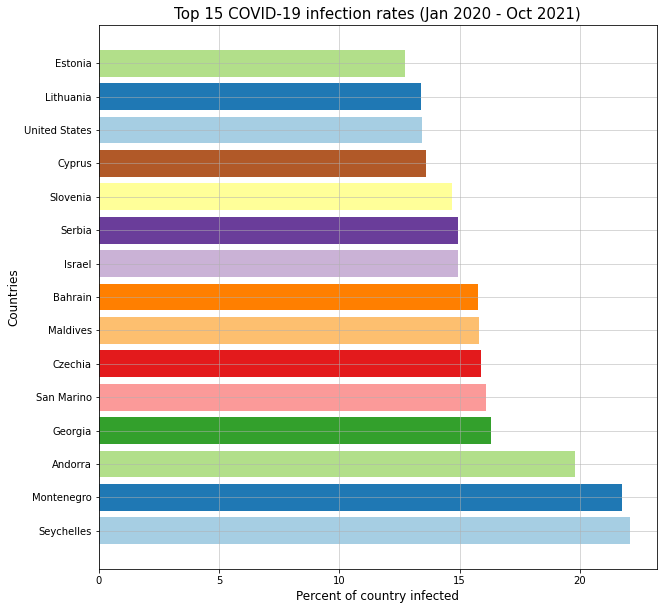

In [24]:
# Create a bar chart
col_map = plt.get_cmap('Paired')

# Set default figure size
plt.rcParams["figure.figsize"] = (10, 10)

plt.barh(top15.location, top15.percent_infected, label='Infections', color=col_map.colors)
plt.title('Top 15 COVID-19 infection rates (Jan 2020 - Oct 2021)', fontsize=15)
plt.grid(linewidth=0.5)
plt.ylabel('Countries', fontsize=12)
plt.xlabel('Percent of country infected', fontsize=12)
plt.show()

The worst infection rates in our Top 15 list range from 12.74% to 22.09%. In particular, three countries stand out from the others at the high end of this list: Seychelles, Montenegro, and Andorra.

## Highest death rates - Top 15 countries
We've identified the highest infection rates in the world. The worst possible outcome of infection is death, so we should look into that as well. In the next chart, we will view the percentage of the population that has died from COVID-19 in the same 15 countries.

In [25]:
# Sort values by highest_death_rate
top15.sort_values(by=['percent_infected'], inplace=True, ascending=False)

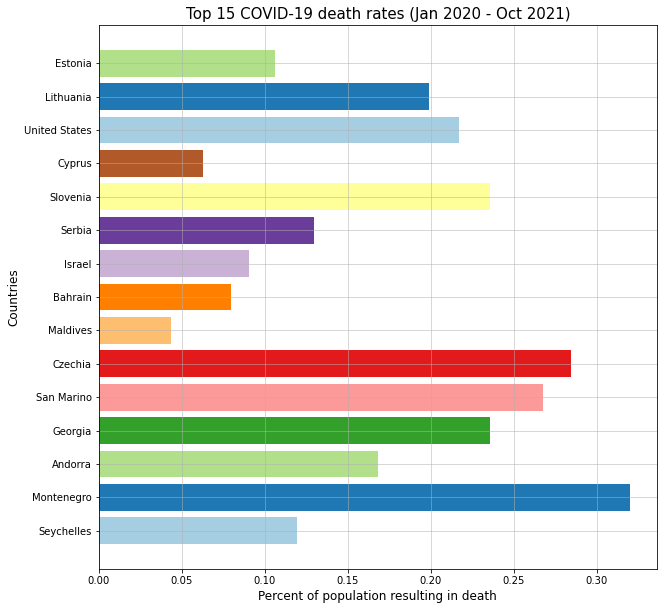

In [26]:
# Create a bar chart
plt.barh(top15.location, top15.percent_dead, label='Dead', color=col_map.colors)
# plt.bar(top15_countries_infection.location+wd, top15_countries_infection.highest_infection_rate, 
        #color='r', width=wd, label='Deaths')

plt.title('Top 15 COVID-19 death rates (Jan 2020 - Oct 2021)', fontsize=15)
plt.grid(linewidth=0.5)
plt.ylabel('Countries', fontsize=12)
plt.xlabel('Percent of population resulting in death', fontsize=12)
plt.show()

As you can see in the bar graph below, there are six countries where the chance of dying from COVID-19 is above 20%. Those countries include the United States, Slovenia, Czechia, San Marino, Georgia, and Montenegro. Some other notable observations:
* Montenegro stands out with the second highest rate of infection and the highest rate of death.
* Czechia has the second highest rate of death in our list, but scores lower in terms of infection rate.
* Given that Seychelles has the highest rate of infection in the world, it has a surprisingly low rate of death.
* The United States scores 13th for infection rate, but 6th for death rate.

# Infections by continent
Next, we will take a look at COVID-19 data from the continent-level. Using a pandas groupby function, we are able to track infections by continent over time.

In [27]:
continents_infections_monthly = covid_continents.groupby(['month_year', 'location'])['total_cases'].aggregate('max').unstack()
continents_infections_monthly.head()

location,Africa,Asia,Europe,International,North America,Oceania,South America
month_year,,,,,,,
2020-01,NaN,9889.0,17.0,NaN,12.0,9.0,NaN
2020-02,3.0,83728.0,1506.0,705.0,50.0,26.0,4.0
2020-03,5779.0,179024.0,465213.0,714.0,205818.0,5212.0,14496.0
2020-04,38753.0,520649.0,1357788.0,721.0,1175287.0,8271.0,180235.0
2020-05,146551.0,1138627.0,1959828.0,721.0,2032863.0,8732.0,901684.0


In [28]:
continents_infections_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2020-01 to 2021-10
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Africa         21 non-null     float64
 1   Asia           22 non-null     float64
 2   Europe         22 non-null     float64
 3   International  21 non-null     float64
 4   North America  22 non-null     float64
 5   Oceania        22 non-null     float64
 6   South America  21 non-null     float64
dtypes: float64(7)
memory usage: 1.4+ KB


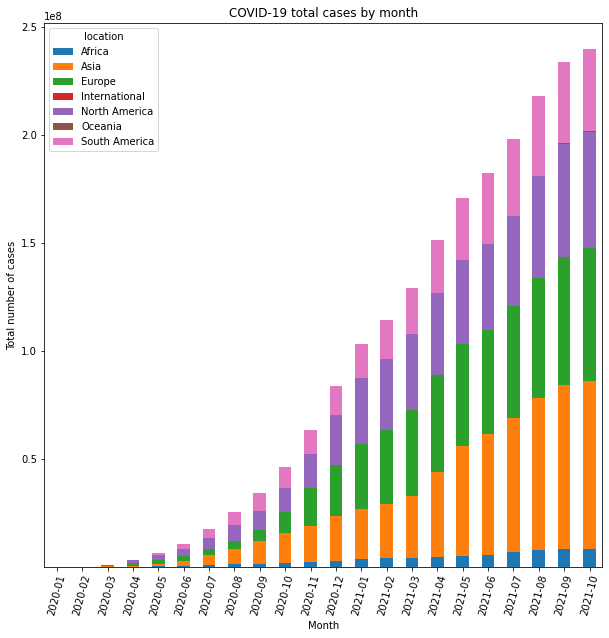

In [29]:
continents_infections_monthly.plot.bar(stacked=True, rot=75, title="COVID-19 total cases by month")
plt.xlabel('Month')
plt.ylabel('Total number of cases')
plt.show(block=True)

In this chart, we see that the infections in Asia, North America, South America, and Europe increase significantly over time. Meanwhile, numbers in Africa are more stable, and Oceania is barely visible.

# Deaths by continent

In [30]:
continents_deaths_monthly = covid_continents.groupby(['month_year', 'location'])['total_deaths'].aggregate('max').unstack()
continents_deaths_monthly.head()

location,Africa,Asia,Europe,International,North America,Oceania,South America
month_year,,,,,,,
2020-01,NaN,213.0,NaN,NaN,NaN,NaN,NaN
2020-02,NaN,2904.0,32.0,6.0,1.0,NaN,NaN
2020-03,200.0,7141.0,31184.0,10.0,5646.0,19.0,484.0
2020-04,1634.0,18703.0,135098.0,15.0,72926.0,112.0,12541.0
2020-05,4222.0,30828.0,172559.0,15.0,126976.0,125.0,56287.0


In [31]:
continents_deaths_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 2020-01 to 2021-10
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Africa         20 non-null     float64
 1   Asia           22 non-null     float64
 2   Europe         21 non-null     float64
 3   International  21 non-null     float64
 4   North America  21 non-null     float64
 5   Oceania        20 non-null     float64
 6   South America  20 non-null     float64
dtypes: float64(7)
memory usage: 1.4+ KB


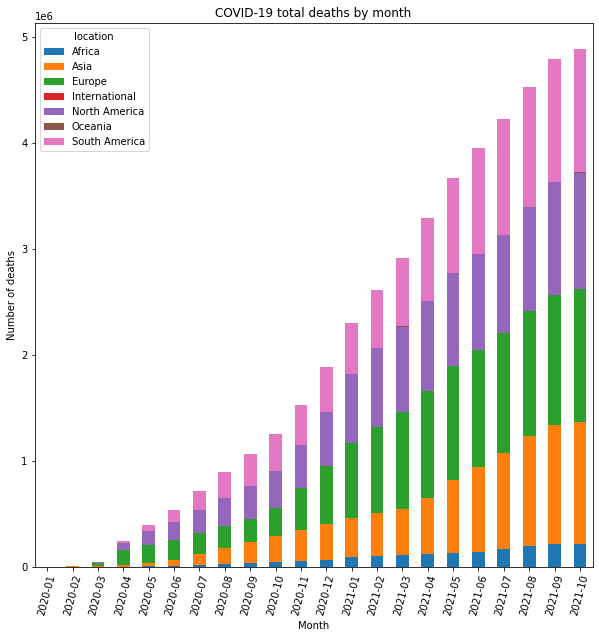

In [32]:
continents_deaths_monthly.plot.bar(stacked=True, rot=75, title="COVID-19 total deaths by month")
plt.xlabel('Month')
plt.ylabel('Number of deaths')
plt.show(block=True)

This chart of deaths by continent basically matches what we saw in the previous chart; we see that deaths in Africa are surprisingly low, and the numbers from Oceania are insignificant.

# A closer look at select countries

In this section, we want to learn how the introduction of vaccines has impacted infections and deaths over time. Our data set is very large, so it will be helpful to limit ourselves to a smaller collection of datapoints. We have selected a group of ten countries that we will examine. The countries selected represent all the major continents, and some were chosen because they received lots of attention by the news media.

In [33]:
# Select ten nations to follow over time
nations_to_follow = ['United States', 'Italy', 'China', 'New Zealand', 'Peru', 'India', 'Iran', 'United Kingdom', 'Switzerland', 'South Africa']
select_data = covid_select.loc[covid_select['location'].isin(nations_to_follow)]

In [34]:
# Drop columns not needed
select_data = select_data[['date', 'location', 'percent_infected', 'percent_dead', 'percent_vaxed']]

In [35]:
# Color scheme for line graphs below
colors = [
    "#F94144", 
    "#F3722C", 
    "#F8961E", 
    "#F9C74F", 
    "#90BE6D",
    "#43AA8B",
    "#4D908E",
    "#577590",
    "#277DA1",
    "#000000"
]

## Percent of population infected
Now, let's take a look at the `percent_infected` data for these countries.

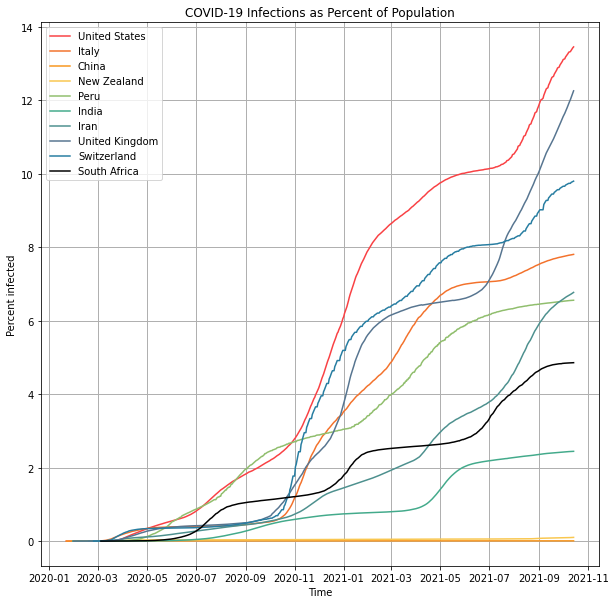

In [36]:
for (n, c) in zip(nations_to_follow, colors):
    selected_rows = select_data[select_data['location'] == n]
    plt.plot(selected_rows.loc[:,"date"], selected_rows.loc[:,"percent_infected"], color=c, label=n)

plt.title("COVID-19 Infections as Percent of Population")
plt.xlabel("Time")
plt.ylabel("Percent infected")
plt.grid(linewidth=1)
plt.legend()
plt.show()

In terms of infection, the USA, UK, and Switzerland are clearly doing the worst overall. However, we are trying to determine the effect of vaccinations on the rate of infection and death over time. Vaccinations began to be administered in the first few months of 2021. When we look at the slope of each line, there appears to be a leveling off of infections soon after. For example, the trajectory of infections in the USA, UK, and Switzerland flattens out somewhat in March of 2021. Later, these same countries all experience a similar increase in infection rate again. Iran and South Africa, on the other hand, seem to have multiple waves with no dramatic decreases.

## Percent of population that died

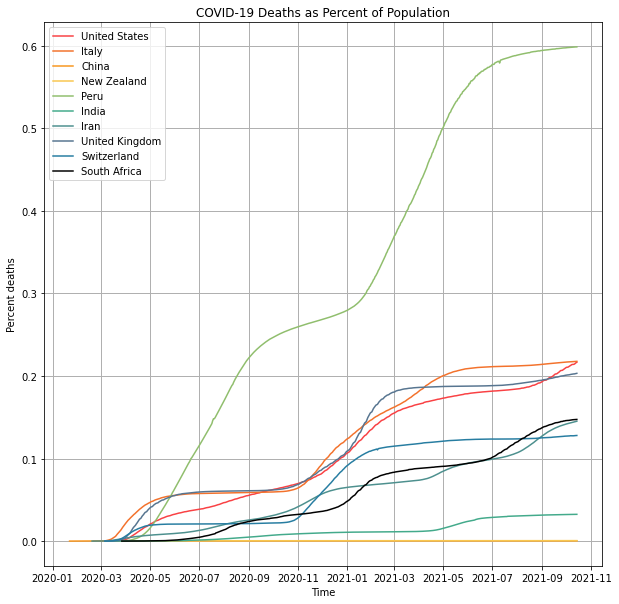

In [37]:
for (n, c) in zip(nations_to_follow, colors):
    selected_rows = select_data[select_data['location'] == n]
    plt.plot(selected_rows.loc[:,"date"], selected_rows.loc[:,"percent_dead"], color=c, label=n)

plt.title("COVID-19 Deaths as Percent of Population")
plt.xlabel("Time")
plt.ylabel("Percent deaths")
plt.grid(linewidth=1)
plt.legend()
plt.show()

The first thing we notice on this chart is the staggering rate of death in Peru compared to the other nations in this chart. Generally speaking, each country's numbers follow its line for infection up until 2021. After that, we see some disparity. In the UK, Italy, and Switzerland, there is a distinct leveling-off of the death rate in or after March. In the USA, the trend is similar but less significant. We don't see much leveling-off in Iran or in South Africa, however.

## Percent of population to receive vaccine

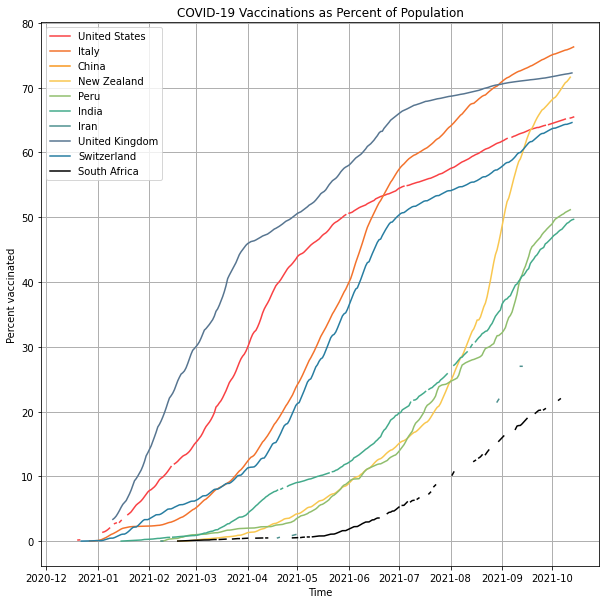

In [38]:
for (n, c) in zip(nations_to_follow, colors):
    selected_rows = select_data[select_data['location'] == n]
    plt.plot(selected_rows.loc[:,"date"], selected_rows.loc[:,"percent_vaxed"], color=c, label=n)


plt.title("COVID-19 Vaccinations as Percent of Population")
plt.xlabel("Time")
plt.ylabel("Percent vaccinated")
plt.grid(linewidth=1)
plt.legend()
plt.show()

The earliest vaccinations occurred at the end of 2020 and then increase sharply across most nations in our group. In the UK and USA, the highest rate of vaccination is in the first half of 2020. In our previous two charts, we saw a flattening of the infection and death rates that corresponds to these vaccination numbers. If we follow the line for vaccinations in the UK, we see that it flattens around April 2021. A similar observation can be made for the USA, Switzerland, Italy, and China. South Africa's reporting of vaccinations appears to be very spotty, while Iran appears to report their vaccination numbers very rarely. However, both countries show a general increase in vaccinations.

## New cases, deaths, vaccinations
Previously, we were looking at the *total* cases, deaths, and vaccinations for a group of countries. We will now look at the **new** cases, deaths, and vaccinations for the same countries and display it using a circle chart in altair. To help make the chart more readable, we will use monthly values instead of daily.

In [39]:
# Prepare new dataframe for monthly data
monthly_data = pd.DataFrame(columns = ['country', 'new_cases', 'new_deaths', 'new_vaxes', 'month_year'])

In [40]:
# Create list of month datetime objects in our data set
months = list(pd.date_range(start='1/1/2020', end='10/1/2021', freq='MS').strftime("%Y-%m"))

In [41]:
#nations_to_follow = ['United States', 'Italy', 'China', 'New Zealand', 'Peru', 'India', 'Iran', 'United Kingdom', 'Switzerland', 'South Africa']
for n in nations_to_follow: 

    for m in months:
        selected_rows = covid_countries[(covid_countries['location'] == n) & 
                                         (covid_countries['month_year'] == m)]        
        # Calculations
        cases = selected_rows['new_cases'].sum()
        deaths = selected_rows['new_deaths'].sum()
        vaxes = selected_rows['new_vaccinations'].sum()

        # Add to dataframe
        monthly_data = monthly_data.append({'country' : n, 'new_cases' : cases, 'new_deaths' : deaths, 'new_vaxes' : vaxes, 'month_year' : m }, ignore_index=True)

In [42]:
monthly_data

,country,new_cases,new_deaths,new_vaxes,month_year
0,United States,7.0,0.0,0.0,2020-01
1,United States,17.0,1.0,0.0,2020-02
2,United States,192054.0,5361.0,0.0,2020-03
3,United States,888863.0,60825.0,0.0,2020-04
4,United States,718732.0,41546.0,0.0,2020-05
...,...,...,...,...,...
215,South Africa,308355.0,4141.0,1572908.0,2021-06
216,South Africa,473482.0,11366.0,1742677.0,2021-07
217,South Africa,330205.0,10248.0,1946671.0,2021-08
218,South Africa,125013.0,5365.0,2697226.0,2021-09


In [43]:
alt.Chart(monthly_data).mark_circle().encode(
    x='month_year', #'monthdate(month_year):O'
    y='country',
    color='country',
    size=alt.Size(
        'new_cases:Q',
        scale=alt.Scale(range=[0,900]),
        legend=alt.Legend(title='Daily new cases')
    )
).properties(
    width=500,
    height=300,
    title='New cases of COVID-19'
)

alt.Chart(...)

# COVID-19 data for the United States

Now that we've got a global picture, let's isolate data for the USA with visualizations from the altair library for Python. These charts will be interactive. This will help us see if vaccinations are successfully preventing infections and deaths related to COVID-19 in the USA.

In [44]:
# Create new dataframe for USA rows
usa = covid_select[covid_select['location'] == "United States"]
usa = usa[['date', 'new_cases', 'new_vaccinations', 'new_deaths', 'total_cases', 'total_vaccinations', 'total_deaths']]
usa.tail(3)

,date,new_cases,new_vaccinations,new_deaths,total_cases,total_vaccinations,total_deaths
117913,2021-10-12,106308.0,NaN,2416.0,44562693.0,403576826.0,716471.0
117914,2021-10-13,121457.0,794421.0,3087.0,44684150.0,404371247.0,719558.0
117915,2021-10-14,83756.0,1073311.0,2005.0,44767906.0,405444558.0,721563.0


In order to display the USA data in a circle chart using the `altair` library, we need the data in a slightly different form. For each day that we have data, there will need to be a separate row for each kind of data that we want to display. 

On the first graph, we'll plot:
* `new_cases`
* `new_deaths` 
* `new_vaccinations`

On the second graph:
* `total_cases`
* `total_deaths`
* `total_vaccinations`

In [45]:
# Create two empty dataframes
usa_new = pd.DataFrame(columns = ['date', 'type', 'count'])
usa_total = pd.DataFrame(columns = ['date', 'type', 'count'])

In [46]:
# Process our USA dataframe row by row and append it to our new dataframes
def get_usa_data(usa):
    global usa_new, usa_total
    
    for i in usa.index:
        # get data from original df
        d = usa['date'][i]
        n_cases = usa['new_cases'][i]
        n_vaxes = usa['new_vaccinations'][i]
        n_deaths = usa['new_deaths'][i]
        t_cases = usa['total_cases'][i]
        t_vaxes = usa['total_vaccinations'][i]
        t_deaths = usa['total_deaths'][i]

        # add data to df in six rows
        usa_new = usa_new.append({'date' : d, 'type' : 'new_cases', 'count' : n_cases }, ignore_index=True)
        usa_new = usa_new.append({'date' : d, 'type' : 'new_deaths', 'count' : n_deaths }, ignore_index=True)
        usa_new = usa_new.append({'date' : d, 'type' : 'new_vaccinations', 'count' : n_vaxes }, ignore_index=True)
        usa_total = usa_total.append({'date' : d, 'type' : 'total_cases', 'count' : t_cases }, ignore_index=True)
        usa_total = usa_total.append({'date' : d, 'type' : 'total_deaths', 'count' : t_deaths }, ignore_index=True)
        usa_total = usa_total.append({'date' : d, 'type' : 'total_vaccinations', 'count' : t_vaxes }, ignore_index=True)
        
get_usa_data(usa)

Now we have our data structured correctly for display as a circle chart.

In [47]:
# Verify contents of dataframe
usa_new

,date,type,count
0,2020-01-22,new_cases,NaN
1,2020-01-22,new_deaths,NaN
2,2020-01-22,new_vaccinations,NaN
3,2020-01-23,new_cases,0.0
4,2020-01-23,new_deaths,NaN
...,...,...,...
1891,2021-10-13,new_deaths,3087.0
1892,2021-10-13,new_vaccinations,794421.0
1893,2021-10-14,new_cases,83756.0
1894,2021-10-14,new_deaths,2005.0


In [48]:
# Setting colors for chart: cases = yellow, deaths = red, vaxes = green
scale = alt.Scale(domain=['new_cases', 'new_deaths', 'new_vaccinations'],
                  range=['#ffcc00', '#cc3300', '#99cc33'])

In [49]:
# Disables maximum number of rows limit for altair visualizations
alt.data_transformers.disable_max_rows()

alt.Chart(usa_new).mark_circle(size=50).encode(
    alt.X('date:T', title='date'),
    alt.Y('count:Q', title='count'),
    alt.Color('type', scale=scale, title='Type of data'),
    alt.Tooltip('date:T')
).properties(
    width=500,
    height=300,
    title='USA & COVID-19: New cases, deaths, vaccinations'
).interactive()

alt.Chart(...)

In the interactive chart above, the most dramatic feature is the extremely large number of vaccinations taking place around April of 2021. We see the greatest reduction in new cases around June, which is about two months after the peak of vaccinations. Feel free to zoom in for a closer look at this interactive chart.

In the previous chart, we looked at *new* cases, deaths, and vaccinations. In our final chart, we will take a look at **total** cases, deaths, and vaccinations.

In [50]:
# Verify contents of dataframe
usa_total

,date,type,count
0,2020-01-22,total_cases,1.0
1,2020-01-22,total_deaths,NaN
2,2020-01-22,total_vaccinations,NaN
3,2020-01-23,total_cases,1.0
4,2020-01-23,total_deaths,NaN
...,...,...,...
1891,2021-10-13,total_deaths,719558.0
1892,2021-10-13,total_vaccinations,404371247.0
1893,2021-10-14,total_cases,44767906.0
1894,2021-10-14,total_deaths,721563.0


In [51]:
# Setting colors for chart: cases = yellow, deaths = red, vaxes = green
scale = alt.Scale(domain=['total_cases', 'total_deaths', 'total_vaccinations'],
                  range=['#ffcc00', '#cc3300', '#99cc33'])

In [52]:
alt.Chart(usa_total).mark_circle(size=20).encode(
    alt.X('date:T', title='date'),
    alt.Y('count:Q', title='count'),
    alt.Color('type', scale=scale, title='Type of data'),
    alt.Tooltip('date:T')
).properties(
    width=500,
    height=300,
    title='USA & COVID-19: Total cases, deaths, vaccinations'
).interactive()

alt.Chart(...)

Although the graph is less striking, we can see a flattening of the line that represents total cases starting around May or June of 2021. Generally, it supports the observations we saw in the graph showing new cases, deaths, and vaccinations.

# Conclusion

In this project, we explored and visualized a large set of COVID-19 data with daily values for every country in the world. Below is the list of our original questions and the answers that we can draw from the data set.

1. *In which countries is COVID-19 the biggest problem proportionate to population?*

The following countries may be the very worst in the world:
* **Peru** has an extremely high rate of death. If you catch COVID-19 in Peru, you 
* **Montenegro** has possibly has the worst COVID-19 problem in the world. They have the second highest rate of infection and the highest rate of death.
* **Czechia** has the second highest rate of death in our list, and is 6th highest in infections.
* **United States** scores very high on both infections and deaths. However, its rate of vaccination lags behind other nations with similar access to vaccines.

2. How is each continent faring with COVID-19?

We see that North America, South America, Europe, and Asia have significant numbers of infections and deaths related to COVID-19. Africa has much lower numbers and more moderate increases. Meanwhile, Oceania has had extremely limited numbers.

3. How have vaccinations altered the trajectory of new infections around the world?

Given the data in our set, a high vaccination rate appears to coincide with a reduction in infections and death. Countries that rolled out vaccinations more quickly and in greater numbers produced a more dramatic reduction in both infections and deaths. However, we see infections and deaths increase again when vaccination rates wane.

4. Are vaccinations working in the USA?

In the USA, we saw the peak vaccination rate in April 2021. There was a corresponding drop off of infections and deaths in the months directly afterward. Similarly, we see an increase in infections and deaths starting in August after a significant reduction in vaccinations in June and July. As of the last day in our data set, only about 70% of the USA is vaccinated. This data suggests that vaccinations are at last partly effective, but unvaccinated people may play a significant role in muting those effects.